# Importing Modules

In [1]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding ,Dropout
from keras.layers import LSTM
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

Using TensorFlow backend.


# Importing dataset

In [2]:
df=pd.read_csv("../data/input/ESNT.csv")

# 1. Preprocessing the data

In [3]:
df['Date']= pd.to_datetime(df['Date'], format="%Y-%m-%d")
df = df.sort_values(by='Date', ascending=True)
df.index = df.Date
del df["Date"]

# 2. Ethereum Price by year wise

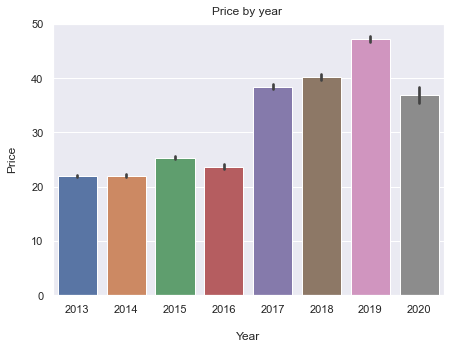

In [4]:
sns.set(rc={'figure.figsize':(7,5)})
sns.barplot(x=df.index.year, y=df["Close"], data=df)
plt.xlabel("Year", labelpad=17)
plt.ylabel("Price", labelpad=14)

plt.title("Price by year ", y=1.01);

# 3. Monthly total for stock values

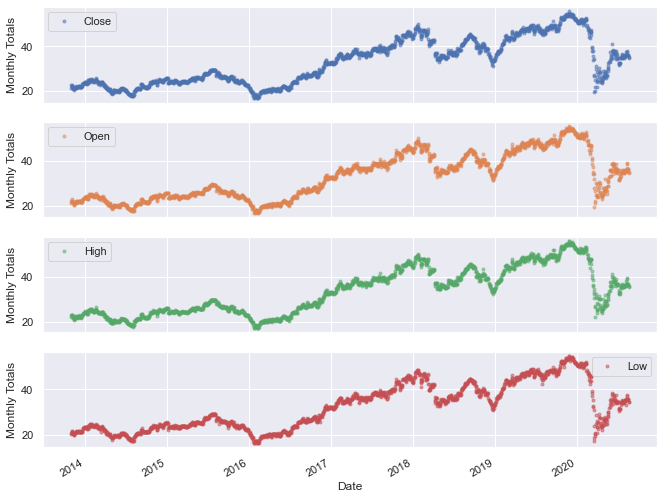

In [5]:
cols_plot = ["Close","Open","High","Low"]
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Monthly Totals')

# 5. Volume flow by year wise

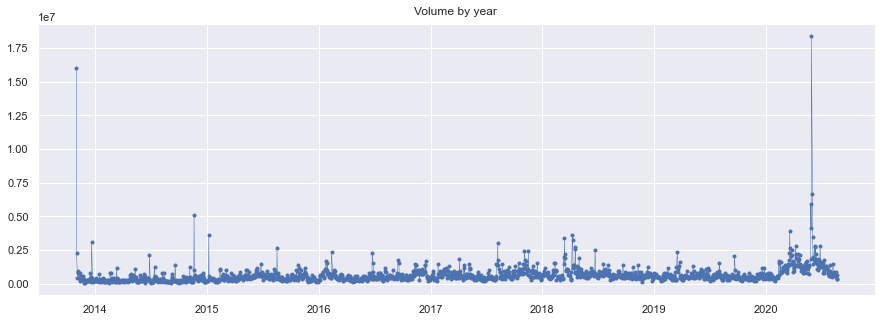

In [6]:
sns.set(rc={'figure.figsize':(15,5)})
start, end = '2010', '2020'
plt.plot(df.loc[start:end, 'Volume'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
plt.title("Volume by year ", y=1.01);

# 6. Auto-correlation and Partial-correlation

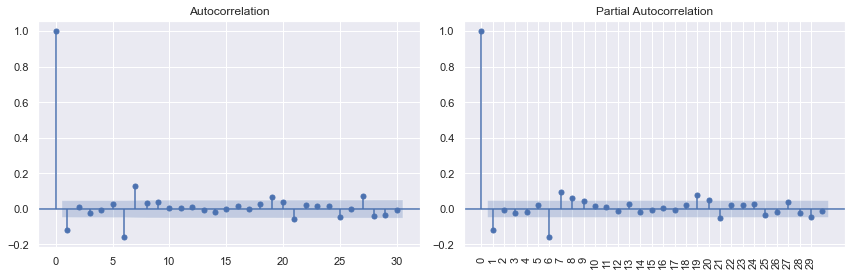

In [7]:
data=df["Close"]

feature_ts_train_diff = data.diff(periods=1)
feature_ts_train_diff.dropna(inplace=True)

feature_ts_train_diff

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(feature_ts_train_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(feature_ts_train_diff, lags=30, ax=axes[1])
plt.tight_layout()

### we can see the negative correlation with partial and autocorrelation.

# 7. Statistic and P-value

In [8]:
dftest = adfuller(data)
print("Statistics",dftest[0])
fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = dftest[1],
    title = {'text': "P value"},
    domain = {'x': [0, 1], 'y': [0, 1]}
))


fig.show()

Statistics -1.7893612485039092


### p-value > 0.05: Does not Rejects the null hypothesis (H0), the data have a unit root and is stationary.

# 8. Preprocessing the data for Recurrent Neural Network

In [9]:
ethe_train = data.loc[:"2019-06-30"].values
ethe_test = data.loc["2019-06-30":"2020"].values

In [10]:
ethe_train=ethe_train.reshape(-1, 1)
scaler = MinMaxScaler(feature_range = (0, 1))

ethe_training_scaled = scaler.fit_transform(ethe_train)
ethe_training_scaled

features_set = []
labels = []
for i in range(60, ethe_train.shape[0]):
    features_set.append(ethe_training_scaled[i-60:i, 0])
    labels.append(ethe_training_scaled[i, 0])

features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

# 9. Building and fitting the LSTM model to the train dataset

In [11]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(features_set, labels, epochs = 50, batch_size = 32)


Epoch 1/50
1364/1364 [==============================] - 13s 10ms/step - loss: 0.0384

# 10. Comparing the model with actual value and predicted value

In [12]:
test_inputs = data[len(data) - len(ethe_test) - 60:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

test_features = []
for i in range(60, test_inputs.shape[0]):
    test_features.append(test_inputs[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

In [13]:
prediction_index = df.index[-predictions.shape[0]:]

In [16]:
df_prediction = pd.DataFrame(
    data = {'prediction' : np.ravel(predictions)},
    index = prediction_index
)

In [18]:
df_bis = df.merge(df_prediction, left_index=True, right_index=True)


<AxesSubplot:xlabel='Date'>

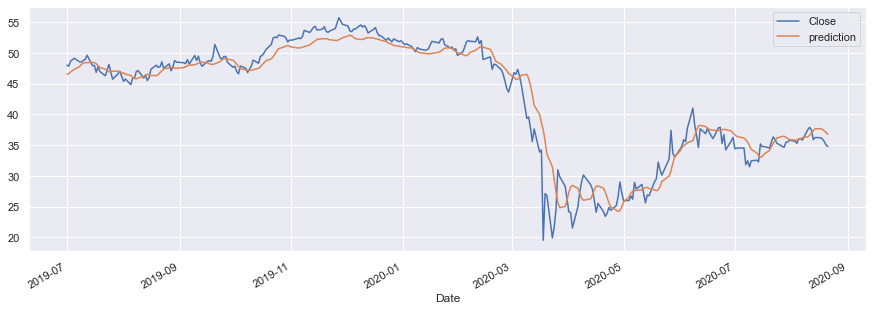

In [21]:
df_bis[["Close", "prediction"]].plot()

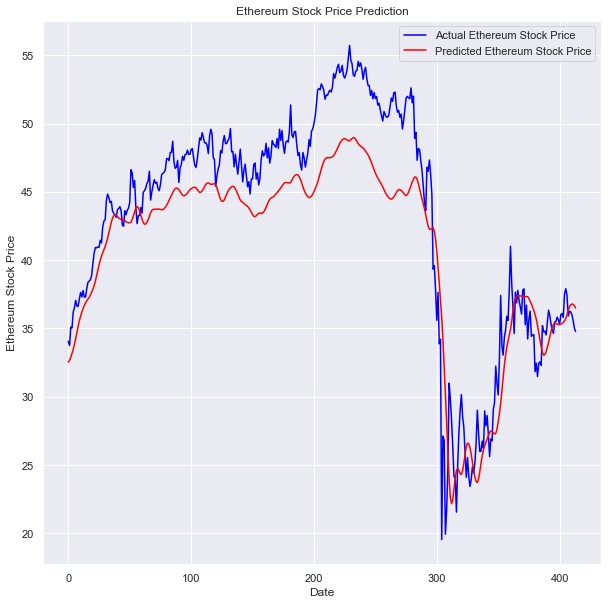

In [63]:
plt.figure(figsize=(10,10))
plt.plot(ethe_test, color='blue', label='Actual Ethereum Stock Price')
plt.plot(predictions , color='red', label='Predicted Ethereum Stock Price')
plt.title('Ethereum Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Ethereum Stock Price')
#plt.ylim(0,500)
plt.legend()
plt.show()


# Prédiction jusqu'au 2020-06-22

In [65]:
test_inputs = data["2019-01-01":"2020-06-22"].values
test_inputs = np.array(test_inputs).reshape(-1, 1)
test_inputs = scaler.fit_transform(test_inputs)


test_features = []
for i in range(60, test_inputs.shape[0]):
    test_features.append(test_inputs[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

In [72]:
new_index = data["2019-01-01":"2020-06-22"].index[-predictions.shape[0]:]

In [79]:
new_df = pd.Series(data=np.ravel(predictions), index=new_index)

<AxesSubplot:xlabel='Date'>

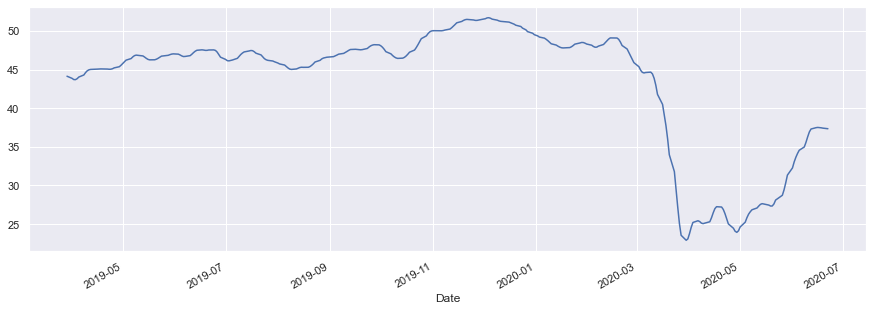

In [80]:
new_df.plot()